# Shift Vs Beta Explorations

This notebook explores the relationship between the shift and beta parameters.
The intuition is that the marginal distribution of the $\beta$ parameters is peaked near zero, so if mutation effects change drastically, a previously deleterious mutation will likley become neutral, but not vice versa.

In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

Load some example betas

In [2]:
df = pd.read_csv('shift_vs_beta_explorations.betas.csv', index_col=0)
df["mutation type"] = np.where(df.index.str.contains("\*"), "nonsense", "missense")
df

,β,mutation type
mutation,,
M1I,-5.267740,missense
F2L,0.208533,missense
V3A,-0.019572,missense
V3F,-0.315474,missense
V3G,0.018503,missense
...,...,...
S1252T,-0.177964,missense
S1252V,0.232335,missense
S1252W,0.225708,missense


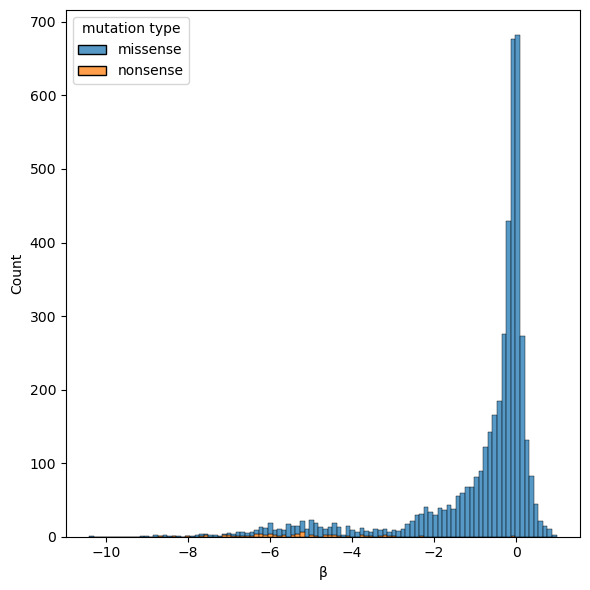

In [3]:
plt.figure(figsize=(6, 6))
sns.histplot(data=df, x="β", hue="mutation type", multiple="stack")
plt.tight_layout()
plt.show()

We will take this as a marginal prior for betas that undergo shifts when we look at a different homolog. However, we will incorporate a scaling parameters that models bulk shift in mutation effects across homologs.

In [4]:
scaling = 0.5

Fit KDEs to scaled betas to define the prior.

In [5]:
# Generate KDEs from the empirical sample
missense_prior = scipy.stats.gaussian_kde(scaling * df.query("`mutation type` == 'missense'").β, bw_method=0.1)
nonsense_prior = scipy.stats.gaussian_kde(scaling * df.query("`mutation type` == 'nonsense'").β, bw_method=0.5)

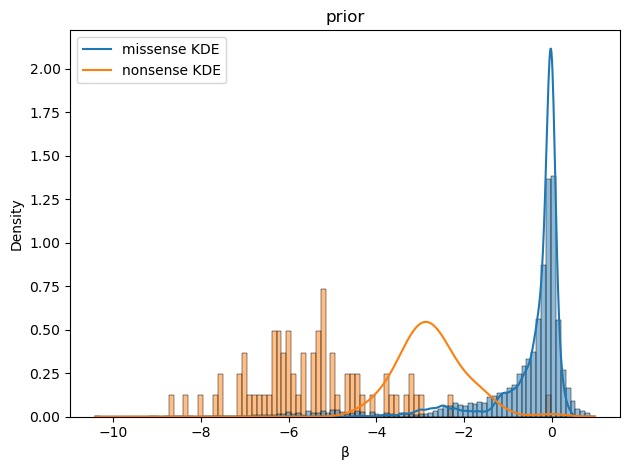

In [6]:
x_grid = np.linspace(df.β.min(), df.β.max(), 1000)

sns.histplot(data=df, x="β", hue="mutation type", stat="density", common_norm=False, alpha=0.5)
plt.plot(x_grid, missense_prior(x_grid), label='missense KDE')
plt.plot(x_grid, nonsense_prior(x_grid), label='nonsense KDE')
plt.legend()
plt.title("prior")
plt.tight_layout()
plt.show()

Now say we have a Cauchy likelihood for the shifted $\beta$, centered on the reference $\beta_{\text{ref}}$.

In [7]:
def posterior(prior, x0, x, scale):
    # note: this is not normalized
    return prior(x) * scipy.stats.cauchy.pdf(x, loc=x0, scale=scale)

def posterior_sample(prior, x, x_grid, scale):
    return np.random.choice(x_grid, p=posterior(prior, x, x_grid, scale) / posterior(prior, x, x_grid, scale).sum())

Based on HH's shift CDF plots, this looks like the sparsity for missense and nonsense mutants

In [8]:
shift_sparsity_missense = 0.2
shift_sparsity_nonsense = 0.99

In [9]:
# Cauchy scale parameter
σ = 0.3

x_grid = np.linspace(df.β.min(), df.β.max(), 500)

Plot the posterior distribution of the shifted $\beta$ parameter for two cases: (1) a mutation that is deleterious in the reference homolog (orange), and (2) a mutation that is neutral in the reference homolog (blue).
We see that the posterior distribution is peaked near zero for both cases, but for the deleterious mutation, the posterior is bimodal, with a peak near the reference $\beta$ and a peak near zero.

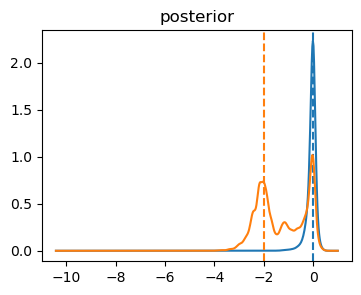

In [10]:
plt.figure(figsize=(4, 3))
plt.plot(x_grid, posterior(missense_prior, 0, x_grid, σ), color='C0')
plt.axvline(0, color='C0', linestyle='--')
plt.plot(x_grid, 20 * posterior(missense_prior, -2, x_grid, σ), color='C1')
plt.axvline(-2, color='C1', linestyle='--')
plt.title("posterior")
plt.show()

In [11]:
df["resampled β"] = df["β"].copy()

missense_idxs = df.query("`mutation type` == 'missense'").index
nonsense_idxs = df.query("`mutation type` == 'nonsense'").index

missense_shifted_idxs = np.random.choice(missense_idxs, round((1 - shift_sparsity_missense) * len(missense_idxs)), replace=False)
nonsense_shifted_idxs = np.random.choice(nonsense_idxs, round((1 - shift_sparsity_nonsense) * len(nonsense_idxs)), replace=False)

for i, idx in enumerate(missense_shifted_idxs, 1):
    df.loc[idx, "resampled β"] = posterior_sample(missense_prior, df.β[idx], x_grid, σ)
    print(f"missense posterior samples: {i / len(missense_shifted_idxs):.2%}", end="\r")

for i, idx in enumerate(nonsense_shifted_idxs, 1):
    df.loc[idx, "resampled β"] = posterior_sample(nonsense_prior, df.β[idx], x_grid, σ)
    print(f"nonsense posterior samples: {i / len(nonsense_shifted_idxs):.2%}", end="\r")

# df.loc[idx, "resampled β"] = missense_pdf.resample(len(missense_shifted_idxs))[0]
# df.loc[nonsense_shifted_idxs, "resampled β"] = nonsense_pdf.resample(len(nonsense_shifted_idxs))[0]

df["shift"] = df["resampled β"] - df["β"]

df

,β,mutation type,resampled β,shift
mutation,,,,
M1I,-5.267740,missense,-0.431390,4.836351
F2L,0.208533,missense,0.048251,-0.160283
V3A,-0.019572,missense,-0.020269,-0.000698
V3F,-0.315474,missense,-0.317189,-0.001715
V3G,0.018503,missense,0.048251,0.029747
...,...,...,...,...
S1252T,-0.177964,missense,-0.317189,-0.139225
S1252V,0.232335,missense,-0.134469,-0.366804
S1252W,0.225708,missense,-0.225829,-0.451538


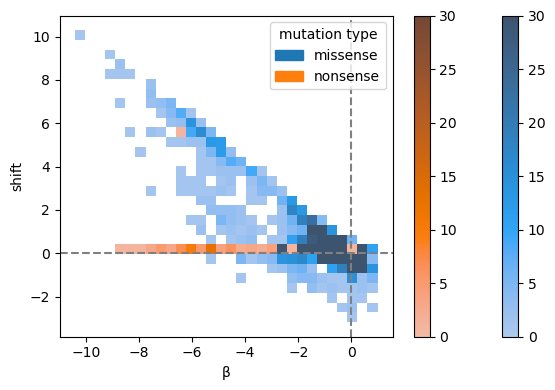

In [12]:
plt.figure(figsize=(6, 4))
g = sns.histplot(data=df, x="β", y="shift", hue="mutation type", bins=30, vmax=30, cbar=True)
sns.move_legend(g, "upper right")
plt.axvline(0, color="grey", linestyle="--")
plt.axhline(0, color="grey", linestyle="--")
plt.tight_layout()
plt.show()